<a href="https://colab.research.google.com/github/alamandaputri/ENSO-LSTM-Prediction/blob/main/Stateless%20and%20Stateful%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Library

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import stats
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import load_model, Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import bds
from tensorflow.keras.utils import plot_model
from scipy.signal import periodogram

## Define Functions


### Normalisasi Minmax

In [ ]:
def minmax(series):
  min = np.min(series)
  max = np.max(series)
  scaled = (series - min)/(max - min)
  return scaled, min, max

### Denormalisasi

In [ ]:
def inverse_minmax(scaled_series, min, max):
  series = scaled_series*(max - min) + min
  return series

### Windowing

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

### Backtesting

In [ ]:
def backtesting_split_into_folds(data, num_folds, test_length):
    """
    Split time series data into folds.

    Parameters:
    - data: numpy array, pandas Series, or list
        The time series data to be split.
    - num_folds: int
        The number of folds to create.

    Returns:
    - folds: list of tuples
        Each tuple contains (train_data, test_data) indices for a fold.
    """
    n = len(data)
    fold_size = n // num_folds

    folds = []
    for i in range(num_folds):
        start = i * fold_size
        end = (i + 1) * fold_size
        train_indices = np.arange(start, end - test_length)
        test_indices = np.arange(end - test_length, end)
        folds.append((train_indices, test_indices))

    return folds

# Example usage:
time_series_data = np.arange(1, 101)
num_folds = 5
folds = backtesting_split_into_folds(time_series_data, num_folds, 6)

for fold, (train_index, test_index) in enumerate(folds):
    train_data, test_data = time_series_data[train_index], time_series_data[test_index]
    print(f"Fold {fold + 1} - Train data: {train_data}, Test data: {test_data}")

Fold 1 - Train data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14], Test data: [15 16 17 18 19 20]
Fold 2 - Train data: [21 22 23 24 25 26 27 28 29 30 31 32 33 34], Test data: [35 36 37 38 39 40]
Fold 3 - Train data: [41 42 43 44 45 46 47 48 49 50 51 52 53 54], Test data: [55 56 57 58 59 60]
Fold 4 - Train data: [61 62 63 64 65 66 67 68 69 70 71 72 73 74], Test data: [75 76 77 78 79 80]
Fold 5 - Train data: [81 82 83 84 85 86 87 88 89 90 91 92 93 94], Test data: [ 95  96  97  98  99 100]


In [ ]:
def backtesting_split_with_skip(data, fold_size, test_length):
    """
    Split time series data into folds.

    Parameters:
    - data: numpy array, pandas Series, or list
        The time series data to be split.
    - num_folds: int
        The number of folds to create.

    Returns:
    - folds: list of tuples
        Each tuple contains (train_data, test_data) indices for a fold.
    """
    n = len(data)

    folds = []
    start = np.arange(0, n + 1, fold_size)
    train_length = fold_size - test_length
    for i in start:
        # find the end of this pattern
        end_train = i + train_length
        end_test = end_train + test_length
        # check if we are beyond the sequence
        if end_test > n:
            break
        train_indices = np.arange(i, end_train)
        test_indices = np.arange(end_train, end_test)
        folds.append((train_indices, test_indices))

    return folds

## Read CSV file

In [ ]:
dataset = pd.read_excel("/content/drive/MyDrive/FARIZA ALAMANDA PUTRI/Magang BMKG/Data_ENSO_Multivariate_NOAA (bulanan).xlsx")
dataset.head()

,Date,Nino34_anom
0,1950-01-01,-1.62
1,1950-02-01,-1.32
2,1950-03-01,-1.07
3,1950-04-01,-1.11
4,1950-05-01,-1.37


In [ ]:
dataset['Date'] = dataset['Date'].apply(pd.to_datetime)

In [ ]:
dataset.tail()

,Date,Nino34_anom
883,2023-08-01,1.35
884,2023-09-01,1.60
885,2023-10-01,1.72
886,2023-11-01,2.02
887,2023-12-01,2.07


In [ ]:
enso_data = dataset['Nino34_anom']
print(enso_data)

0     -1.62
1     -1.32
2     -1.07
3     -1.11
4     -1.37
       ... 
883    1.35
884    1.60
885    1.72
886    2.02
887    2.07
Name: Nino34_anom, Length: 888, dtype: float64


## Plot Data Sebelum Normalisasi

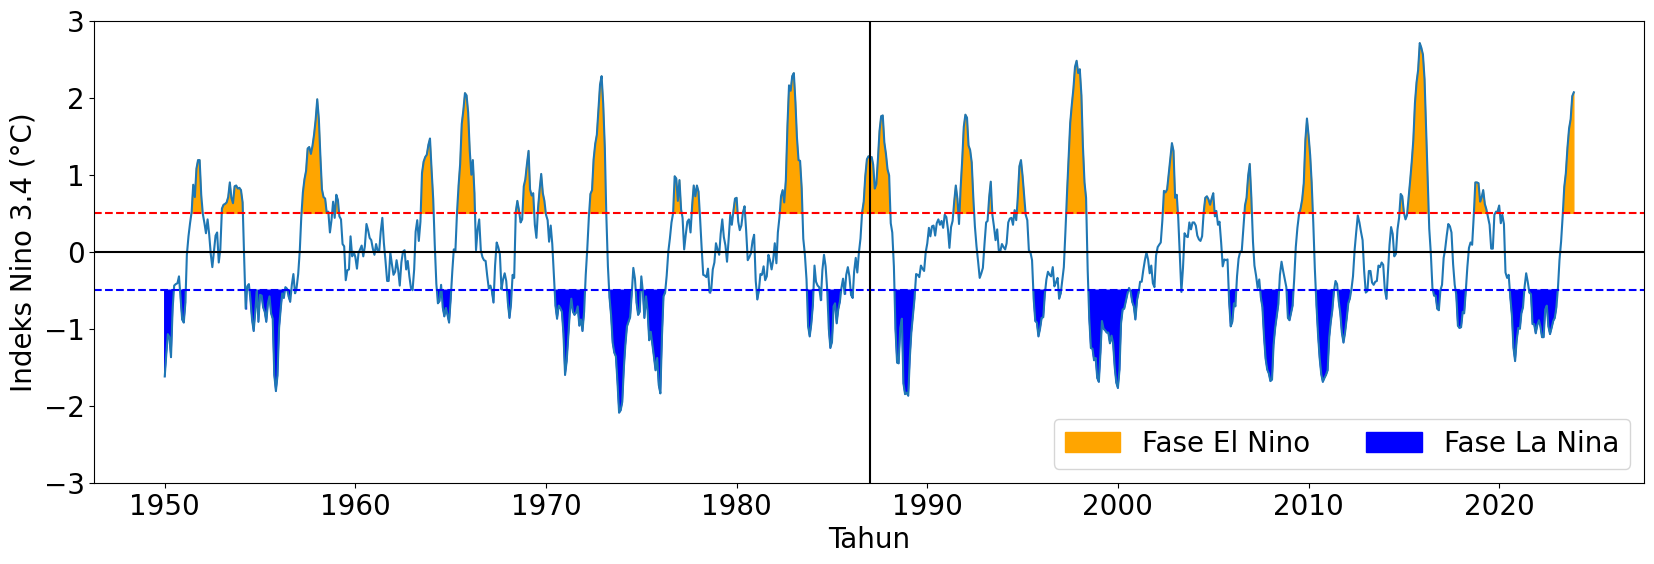

In [ ]:
plt.subplots(figsize = (20,6))
plt.ylim(-3,3)
x = dataset['Date']
y = dataset['Nino34_anom']

plt.plot(x,y)
plt.axhline(y=0.5, color='red', linestyle='--')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=-0.5, color='blue', linestyle='--')
plt.axvline(x=dataset['Date'][444], color='black')

plt.fill_between(x, 0.5, y, where=y > 0.5, color='orange', label = 'Fase El Nino')
plt.fill_between(x, -0.5, y, where=y < -0.5, color='blue', label = 'Fase La Nina')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Tahun", fontsize = "20")
plt.ylabel("Indeks Nino 3.4 (°C)", fontsize = "20")
plt.legend(loc='lower right', fontsize = "20", ncol = 2)

## Scaling Data

In [ ]:
scaled, min_value, max_value = minmax(enso_data)
scaled.describe()

count    888.000000
mean       0.437397
std        0.178890
min        0.000000
25%        0.311979
50%        0.427083
75%        0.543750
max        1.000000
Name: Nino34_anom, dtype: float64

## Plot Data Setelah Normalisasi

Text(0.5, 1.0, 'Indeks Nino 3.4')

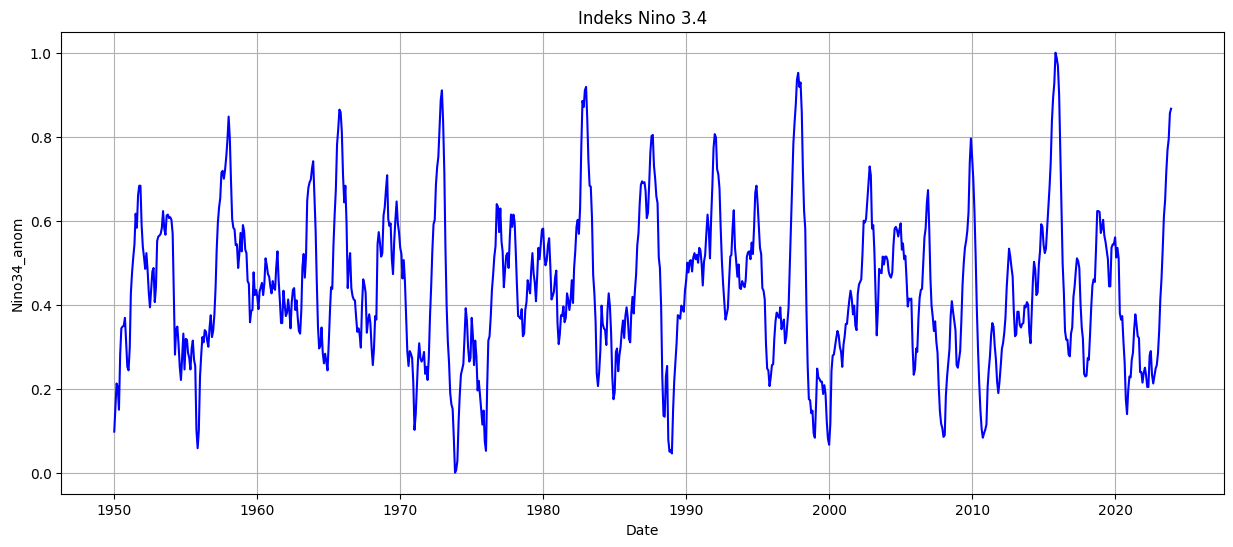

In [ ]:
plt.subplots(figsize = (15,6))
sns.lineplot(x=dataset['Date'], y=scaled, color='blue')

plt.grid()
plt.title("Indeks Nino 3.4")

## Training Stateful LSTM

In [ ]:
class StatefulLSTM:
    def __init__(self, num_time_steps, num_features, num_outputs):
        self.num_time_steps = num_time_steps
        self.num_features = num_features
        self.num_outputs = num_outputs
        self.model = self.build_model()
        self.history = {'loss': [], 'val_loss': []}  # Initialize history dictionary

    def build_model(self):
        model = Sequential()
        model.add(LSTM(64, batch_input_shape=(1, self.num_time_steps, self.num_features), return_sequences=True, stateful=True))
        model.add(LSTM(64, stateful=True))
        model.add(Dropout(0.1))
        model.add(Dense(self.num_outputs))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error')
        return model

    def fit(self, X_train, y_train, num_epochs=50, X_val=None, y_val=None):
        for epoch in range(num_epochs):
            # Use validation data if provided
            if X_val is not None and y_val is not None:
                history = self.model.fit(X_train, y_train, batch_size=1, epochs=1, shuffle=False, validation_data=(X_val, y_val))
                self.history['loss'].extend(history.history['loss'])
                self.history['val_loss'].extend(history.history['val_loss'])
            else:
                history = self.model.fit(X_train, y_train, batch_size=1, epochs=1, shuffle=False)
                self.history['loss'].extend(history.history['loss'])

            self.model.reset_states()

    def predict(self, X):
        return self.model.predict(X, batch_size=1)

    def save_model(self, filename):
        self.model.save(filename)

    def load_model(self, filename):
        self.model = load_model(filename)

In [ ]:
n_steps_in = 6
n_steps_out = 1
n_features = 1

num_folds = 3
scaled_data = np.asarray(scaled)
actual_data = np.asarray(enso_data)

folds = backtesting_split_with_skip(data = scaled_data, fold_size = len(scaled_data)//num_folds, test_length = 12)

lstm_regressor = StatefulLSTM(n_steps_in, n_features, n_steps_out)

overall_mape = 0
overall_rmse = 0
num_folds = 0
for fold, (train_index, test_index) in enumerate(folds):
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]
    x_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
    x_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
    x_pred_test = x_train[-1]

    lstm_regressor.fit(x_train, y_train, X_val = x_test, y_val = y_test)

    predicted_scaled = lstm_regressor.predict(x_test)

    predicted = predicted_scaled
    mape = mean_absolute_percentage_error(y_true = y_test, y_pred = predicted) * 100
    rmse = mean_squared_error(y_true = y_test, y_pred = predicted, squared = False)

    overall_mape += mape
    overall_rmse += rmse
    num_folds += 1
    print(f"Fold {fold + 1} - MAPE: {mape:.2f}% - RMSE: {rmse:.2f}")

print(f"Overall MAPE: {overall_mape/num_folds:.2f}% - Overall RMSE: {overall_rmse/num_folds:.2f}")

6/6 [==============================] - 1s 4ms/step
Fold 1 - MAPE: 9.96% - RMSE: 0.03
6/6 [==============================] - 0s 3ms/step
Fold 2 - MAPE: 30.27% - RMSE: 0.05
6/6 [==============================] - 0s 4ms/step
Fold 3 - MAPE: 6.48% - RMSE: 0.06
Overall MAPE: 15.57% - Overall RMSE: 0.05


### Prediksi 6 periode

In [ ]:
n_steps_in = 6
n_steps_out = 1
n_features = 1

num_folds = 3
scaled_data = np.asarray(scaled)
actual_data = np.asarray(enso_data)

#model = load_model(f"/content/drive/MyDrive/FARIZA ALAMANDA PUTRI/SKRIPSI/Models/model_2layer_64_64_{num_folds}folds_epochs50_lr0005.hdf5")

folds = backtesting_split_with_skip(data = scaled_data, fold_size = len(scaled_data)//num_folds, test_length = 12)

overall_mape = 0
overall_rmse = 0
overall_mse = 0
overall_r2 = 0
for fold, (train_index, test_index) in enumerate(folds):
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]
    x_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
    x_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
    x_pred_test = x_train[-1]

    predicted_scaled = lstm_regressor.predict(x_test)

    # evaluation metrics
    predicted = inverse_minmax(predicted_scaled, min_value, max_value)
    test_target = inverse_minmax(y_test, min_value, max_value)
    mape = mean_absolute_percentage_error(test_target, predicted) * 100
    rmse = mean_squared_error(test_target, predicted, squared = False)
    mse = mean_squared_error(test_target, predicted, squared = True)
    overall_mape += mape
    overall_rmse += rmse
    overall_mse += mse
    print(f"Fold {fold + 1} - MAPE: {mape:.2f}% - RMSE: {rmse:.3f} - MSE: {mse:.3f}")
    print(f"Actual Value: {test_target} \nPredicted Value: {predicted}")

print(f"Overall MAPE: {overall_mape/num_folds:.2f}% - Overall RMSE: {overall_rmse/num_folds:.3f} - Overall MSE: {overall_mse/num_folds:.3f}")

6/6 [==============================] - 0s 5ms/step
Fold 1 - MAPE: 28.67% - RMSE: 0.184 - MSE: 0.034
Actual Value: [[-1.21]
 [-0.97]
 [-0.91]
 [-0.85]
 [-0.55]
 [-0.21]] 
Predicted Value: [[-1.5249014 ]
 [-0.95477116]
 [-0.8702533 ]
 [-0.846051  ]
 [-0.79972196]
 [-0.40773892]]
6/6 [==============================] - 0s 5ms/step
Fold 2 - MAPE: 16.54% - RMSE: 0.231 - MSE: 0.053
Actual Value: [[-1.38]
 [-1.64]
 [-1.69]
 [-1.31]
 [-0.9 ]
 [-1.  ]] 
Predicted Value: [[-1.4996963]
 [-1.319082 ]
 [-1.6928198]
 [-1.586195 ]
 [-1.062592 ]
 [-0.6834117]]
6/6 [==============================] - 0s 4ms/step
Fold 3 - MAPE: 15.28% - RMSE: 0.262 - MSE: 0.069
Actual Value: [[1.02]
 [1.35]
 [1.6 ]
 [1.72]
 [2.02]
 [2.07]] 
Predicted Value: [[0.87612915]
 [1.0089166 ]
 [1.3962913 ]
 [1.516551  ]
 [1.6098225 ]
 [1.9154618 ]]
Overall MAPE: 20.16% - Overall RMSE: 0.226 - Overall MSE: 0.052


In [ ]:
predicted_scaled[]

array([0.6268307], dtype=float32)

In [ ]:
# save model
lstm_regressor.save_model(f"/content/drive/MyDrive/FARIZA ALAMANDA PUTRI/SKRIPSI/Models/model_1layer_32_{num_folds}folds_epochs200_lr0005.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Training Stateless LSTM

In [ ]:
class StatelessLSTM:
    def __init__(self, num_time_steps, num_features, num_outputs):
        self.num_time_steps = num_time_steps
        self.num_features = num_features
        self.num_outputs = num_outputs
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(LSTM(64, batch_input_shape=(None, self.num_time_steps, self.num_features), return_sequences = True))
        model.add(LSTM(64))
        model.add(Dropout(0.1))
        model.add(Dense(self.num_outputs))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005), loss='mean_squared_error')
        return model

    def fit(self, X_train, y_train, num_epochs=50, X_val=None, y_val=None):
        # Use validation data if provided
        if X_val is not None and y_val is not None:
          history = self.model.fit(X_train, y_train, batch_size=1, epochs=num_epochs, shuffle=False, validation_data=(X_val, y_val))
        else:
          history = self.model.fit(X_train, y_train, batch_size=1, epochs=num_epochs, shuffle=False)

    def predict(self, X):
        return self.model.predict(X, batch_size=1)

    def save_model(self, filename):
        self.model.save(filename)

    def load_model(self, filename):
        self.model = load_model(filename)


In [ ]:
n_steps_in = 6
n_steps_out = 6
n_features = 1

num_folds = 3
scaled_data = np.asarray(scaled)
actual_data = np.asarray(enso_data)

folds = backtesting_split_with_skip(data = scaled_data, fold_size = len(scaled_data)//num_folds, test_length = 12)

lstm_regressor = StatelessLSTM(n_steps_in, n_features, n_steps_out)

overall_mape = 0
overall_rmse = 0
num_folds = 0
for fold, (train_index, test_index) in enumerate(folds):
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]
    x_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
    x_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
    x_pred_test = x_train[-1]

    lstm_regressor.fit(x_train, y_train, X_val = x_test, y_val = y_test)
    predicted_scaled = lstm_regressor.predict(x_test)

    predicted = predicted_scaled
    mape = mean_absolute_percentage_error(y_true = y_test, y_pred = predicted) * 100
    rmse = mean_squared_error(y_true = y_test, y_pred = predicted, squared = False)

    overall_mape += mape
    overall_rmse += rmse
    num_folds += 1
    print(f"Fold {fold + 1} - MAPE: {mape:.2f}% - RMSE: {rmse:.2f}")

print(f"Overall MAPE: {overall_mape/num_folds:.2f}% - Overall RMSE: {overall_rmse/num_folds:.2f}")

Epoch 1/50
273/273 [==============================] - 8s 15ms/step - loss: 0.0502 - val_loss: 0.0052
Epoch 2/50
273/273 [==============================] - 2s 6ms/step - loss: 0.0328 - val_loss: 0.0055
Epoch 3/50
273/273 [==============================] - 2s 7ms/step - loss: 0.0311 - val_loss: 0.0055
Epoch 4/50
273/273 [==============================] - 2s 7ms/step - loss: 0.0308 - val_loss: 0.0052
Epoch 5/50
273/273 [==============================] - 2s 7ms/step - loss: 0.0288 - val_loss: 0.0059
Epoch 6/50
273/273 [==============================] - 2s 7ms/step - loss: 0.0280 - val_loss: 0.0054
Epoch 7/50
273/273 [==============================] - 3s 11ms/step - loss: 0.0278 - val_loss: 0.0043
Epoch 8/50
273/273 [==============================] - 3s 10ms/step - loss: 0.0268 - val_loss: 0.0033
Epoch 9/50
273/273 [==============================] - 2s 7ms/step - loss: 0.0246 - val_loss: 0.0030
Epoch 10/50
273/273 [==============================] - 2s 7ms/step - loss: 0.0236 - val_loss: 0.0

### Prediksi 6 periode

1/1 [==============================] - 2s 2s/step
Fold 1 - MAPE: 41.17% - RMSE: 0.334 - R2: 0.732
Actual Value: [-1.21 -0.97 -0.91 -0.85 -0.55 -0.21] 
Predicted Value: [-1.313525   -0.84523    -0.5159755  -0.31976438 -0.10316789 -0.12871826]


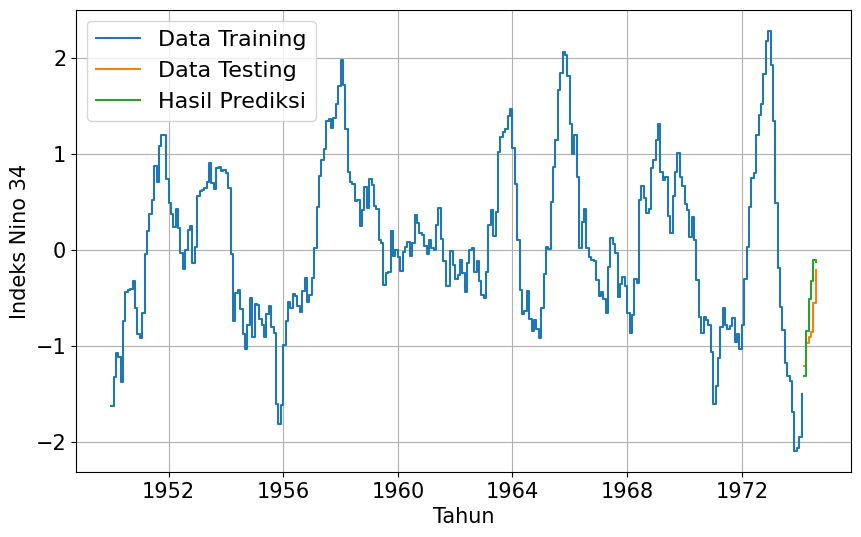

1/1 [==============================] - 0s 27ms/step
Fold 2 - MAPE: 20.77% - RMSE: 0.292 - R2: 0.603
Actual Value: [-1.38 -1.64 -1.69 -1.31 -0.9  -1.  ] 
Predicted Value: [-1.6801369 -1.5039747 -1.2942965 -1.0597491 -0.8093591 -0.580106 ]


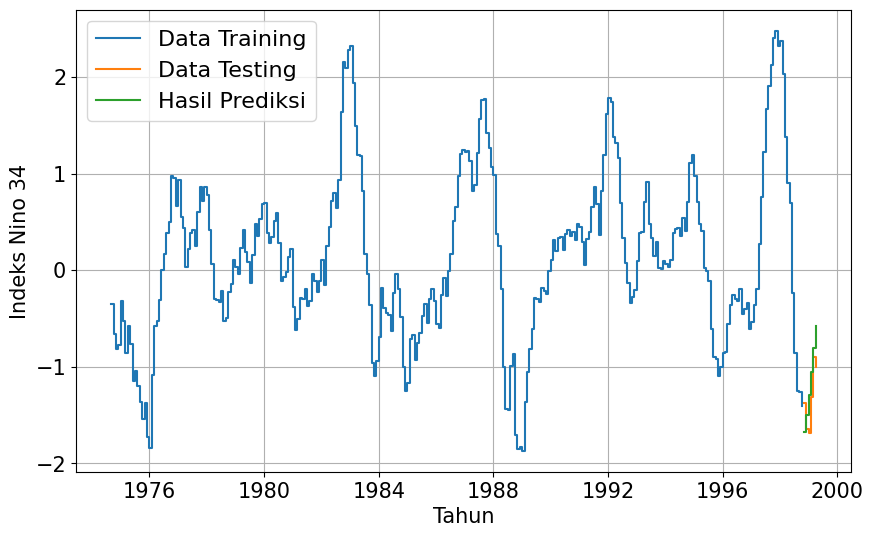

1/1 [==============================] - 0s 24ms/step
Fold 3 - MAPE: 40.18% - RMSE: 0.811 - R2: 0.041
Actual Value: [1.02 1.35 1.6  1.72 2.02 2.07] 
Predicted Value: [0.8573437 0.9666605 1.0032485 0.9896908 0.9059787 0.7897141]


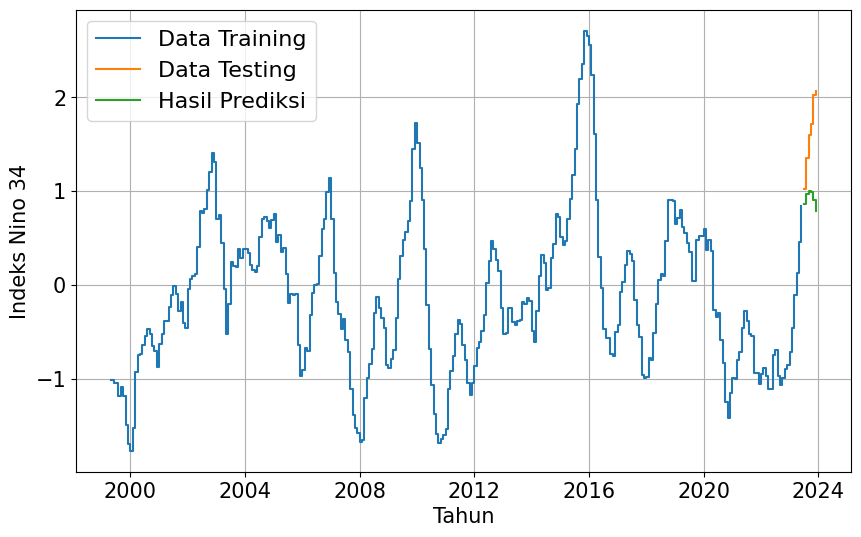

Overall MAPE: 34.04% - Overall RMSE: 0.479 - Overall R2: 0.458


In [ ]:
n_steps_in = 6
n_steps_out = 6
n_features = 1

num_folds = 3
scaled_data = np.asarray(scaled)
actual_data = np.asarray(enso_data)

folds = backtesting_split_with_skip(data = scaled_data, fold_size = len(scaled_data)//num_folds, test_length = 12)

model_stateless = load_model("/content/drive/MyDrive/FARIZA ALAMANDA PUTRI/SKRIPSI/Models/model_2layer_64_64_3folds_epochs50_lr0005(stateless).hdf5")

overall_mape = 0
overall_rmse = 0
overall_r2 = 0
for fold, (train_index, test_index) in enumerate(folds):
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]
    x_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
    x_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
    x_pred_test = x_train[-1]

    predicted_scaled = model_stateless.predict(x_test)

    # evaluation metrics
    predicted = inverse_minmax(predicted_scaled[0], min_value, max_value)
    test_target = inverse_minmax(y_test[0], min_value, max_value)
    mape = mean_absolute_percentage_error(test_target, predicted) * 100
    rmse = mean_squared_error(test_target, predicted, squared = False)
    corr, _ = pearsonr(test_target, predicted)
    r2 = corr**2
    overall_mape += mape
    overall_rmse += rmse
    overall_r2 += r2
    print(f"Fold {fold + 1} - MAPE: {mape:.2f}% - RMSE: {rmse:.3f} - R2: {r2:.3f}")
    print(f"Actual Value: {test_target} \nPredicted Value: {predicted}")

    # plot
    train_data = enso_data[train_index]
    plt.subplots(figsize = (10,6))
    ax=sns.lineplot(x=dataset['Date'][np.concatenate((train_index, test_index[:6]))], y=enso_data[np.concatenate((train_index, test_index[:6]))], drawstyle='steps-post', label='Data Training')
    ax=sns.lineplot(x=dataset['Date'][test_index][-6:], y=test_target, drawstyle='steps-post', label='Data Testing')
    ax=sns.lineplot(x=dataset['Date'][test_index][-6:], y=predicted, drawstyle='steps-post', label='Hasil Prediksi')
    plt.legend(loc='upper left', prop={'size': 16})
    plt.xlabel('Tahun', fontsize=15); plt.ylabel('Indeks Nino 34', fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    plt.grid()
    plt.show()

print(f"Overall MAPE: {overall_mape/num_folds:.2f}% - Overall RMSE: {overall_rmse/num_folds:.3f} - Overall R2: {overall_r2/num_folds:.3f}")

In [ ]:
# save model
lstm_regressor.save_model(f"/content/drive/MyDrive/FARIZA ALAMANDA PUTRI/SKRIPSI/Models/model_2layer_64_64_{num_folds}folds_epochs50_lr0005(stateless).hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## FORECAST

In [ ]:
model = load_model(f"/content/drive/MyDrive/FARIZA ALAMANDA PUTRI/SKRIPSI/Models/model_2layer_64_64_3folds_epochs50_lr0005.hdf5")

In [ ]:
scaled_data = np.asarray(scaled)

In [ ]:
dataset[-8:-2]

,Date,Nino34_anom
880,2023-05-01,0.46
881,2023-06-01,0.84
882,2023-07-01,1.02
883,2023-08-01,1.35
884,2023-09-01,1.60
885,2023-10-01,1.72


In [ ]:
forecast = model.predict(scaled_data[-8:-2].reshape(1,6))
real_forecast = inverse_minmax(forecast[0], min_value, max_value)

1/1 [==============================] - 0s 22ms/step


In [ ]:
real_forecast

array([2.0019338, 1.8764992, 1.6687407, 1.3283596, 0.9534459, 0.6066797],
      dtype=float32)

In [ ]:
np.concatenate((enso_data[-2:], [1.82,1.52,1.12,0.80]))

array([2.02, 2.07, 1.82, 1.52, 1.12, 0.8 ])

In [ ]:
mean_absolute_percentage_error(np.concatenate((enso_data[-2:], [1.82,1.52,1.12,0.80])),real_forecast)*100

11.699506872882665

In [ ]:
forecast = model.predict(scaled_data[-6:].reshape(1,6))
real_forecast = inverse_minmax(forecast[0], min_value, max_value)

1/1 [==============================] - 0s 22ms/step


In [ ]:
real_forecast

array([2.0019338, 1.8764992, 1.6687407, 1.3283596, 0.9534459, 0.6066797],
      dtype=float32)

In [ ]:
df_forecast = pd.DataFrame(columns=['Date'])
df_forecast['Date'] = ['1/1/2024', '2/1/2024', '3/1/2024', '4/1/2024', '5/1/2024', '6/1/2024']
df_forecast['Denormalized'] = [1.9224312 , 1.74681   , 1.4652922 , 1.0176034 , 0.58841777, 0.21735239]
df_forecast['Date'] = df_forecast['Date'].apply(pd.to_datetime)
df_forecast['Normalized'] = (df_forecast['Denormalized']-min_value)/(max_value-min_value)
df_forecast

,Date,Denormalized,Normalized
0,2024-01-01,1.922431,0.835923
1,2024-02-01,1.746810,0.799335
2,2024-03-01,1.465292,0.740686
3,2024-04-01,1.017603,0.647417
4,2024-05-01,0.588418,0.558004
5,2024-06-01,0.217352,0.480698


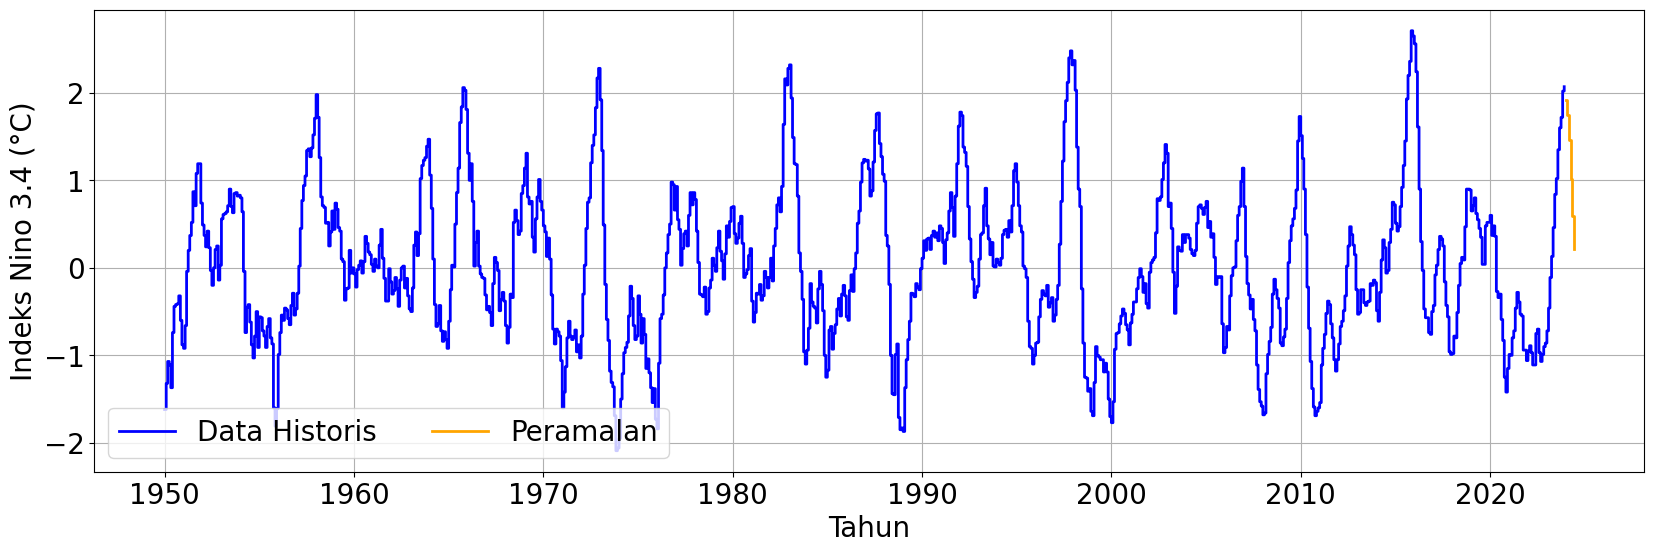

In [ ]:
plt.subplots(figsize = (20,6))

ax=sns.lineplot(x=dataset['Date'], y=dataset['Nino34_anom'], drawstyle='steps-post', label='Data Historis', color = "blue", linewidth = 2)
ax=sns.lineplot(x=df_forecast['Date'], y=df_forecast['Denormalized'], drawstyle='steps-post', label='Peramalan', color = "orange", linewidth = 2)

plt.legend(loc='lower left', prop={'size': 20}, ncol = 2)
plt.xlabel('Tahun', fontsize=20)
plt.ylabel('Indeks Nino 3.4 (°C)', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.grid()
plt.show()

Text(0.5, 1.0, 'Indeks Nino 3.4')

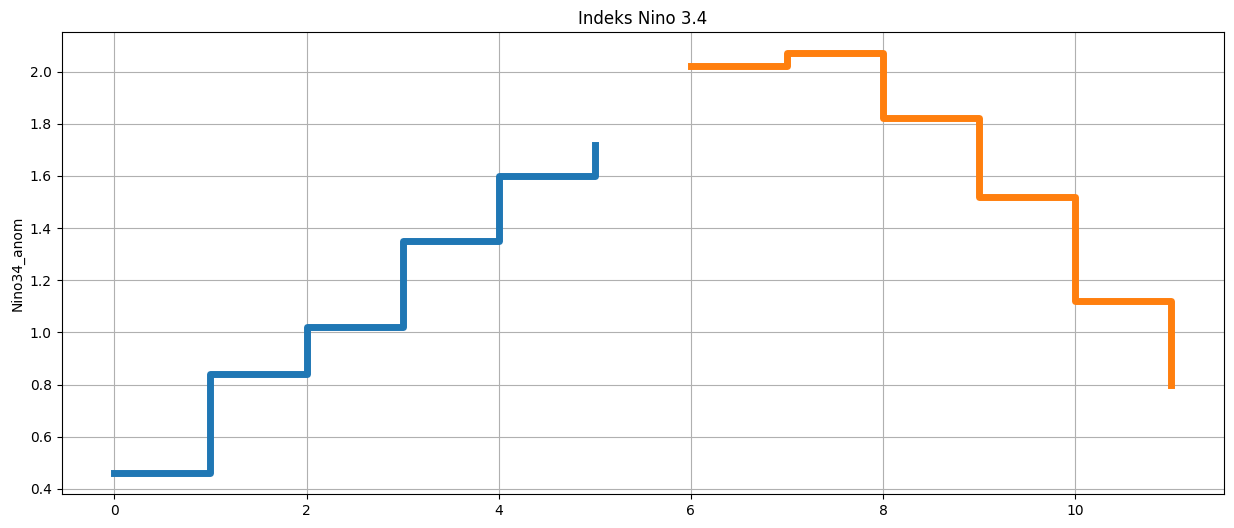

In [ ]:
plt.subplots(figsize = (15,6))
ax=sns.lineplot(x=range(6), y=enso_data[-8:-2], drawstyle='steps-post', linewidth=5)
ax=sns.lineplot(x=range(6,12), y=np.concatenate((enso_data[-2:], [1.82,1.52,1.12,0.80])), drawstyle='steps-post', linewidth=5)

plt.grid()
plt.title("Indeks Nino 3.4")

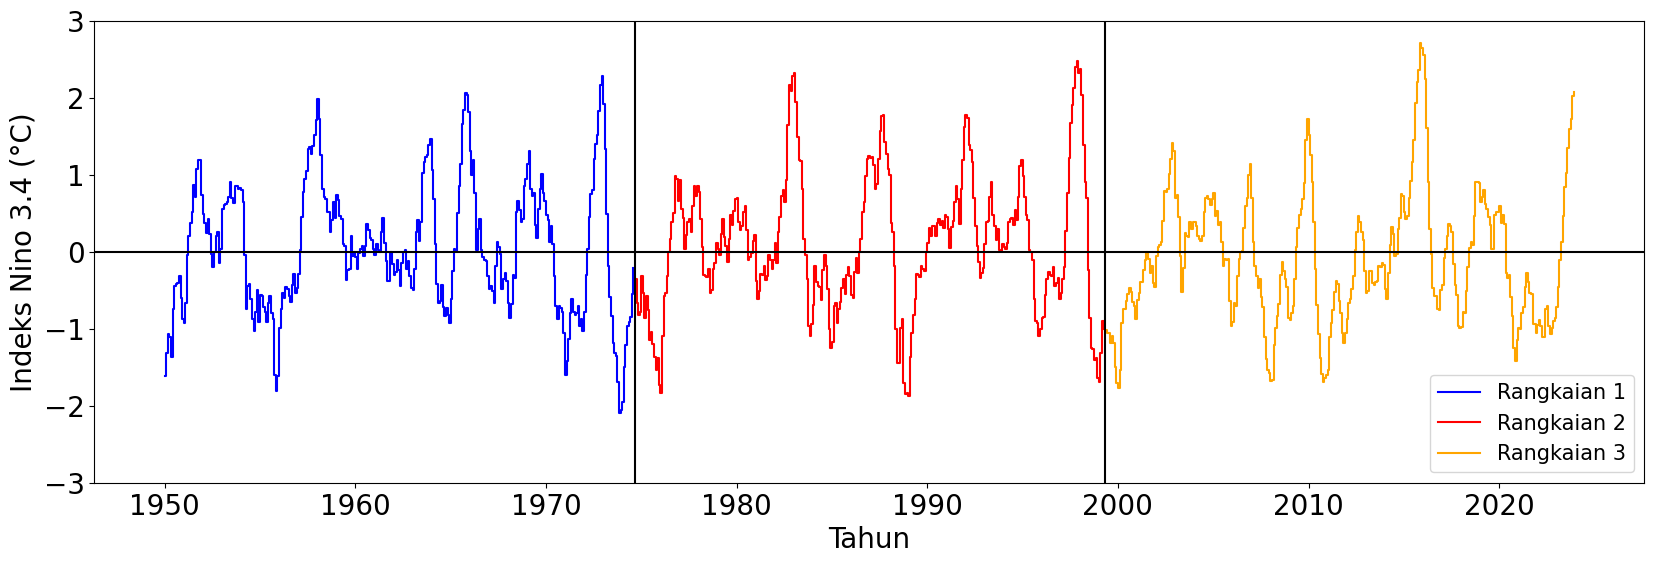

In [ ]:
plt.subplots(figsize = (20,6))
plt.ylim(-3,3)
x = dataset['Date']
y = scaled

plt.plot(dataset['Date'][:296],enso_data[:296], color="blue", drawstyle='steps-post', label = "Rangkaian 1")
plt.plot(dataset['Date'][296:592],enso_data[296:592], color="red", drawstyle='steps-post', label = "Rangkaian 2")
plt.plot(dataset['Date'][592:],enso_data[592:], color="orange", drawstyle='steps-post', label = "Rangkaian 3")
plt.axhline(y=0, color='black')
plt.axvline(x=dataset['Date'][296], color='black')
plt.axvline(x=dataset['Date'][592], color='black')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Tahun", fontsize = "20")
plt.ylabel("Indeks Nino 3.4 (°C)", fontsize = "20")
plt.legend(loc='lower right', fontsize = "15", ncol = 1)

In [ ]:
print(dataset['Date'][296])
print(dataset['Date'][592])

1974-09-01 00:00:00
1999-05-01 00:00:00


## Periodogram

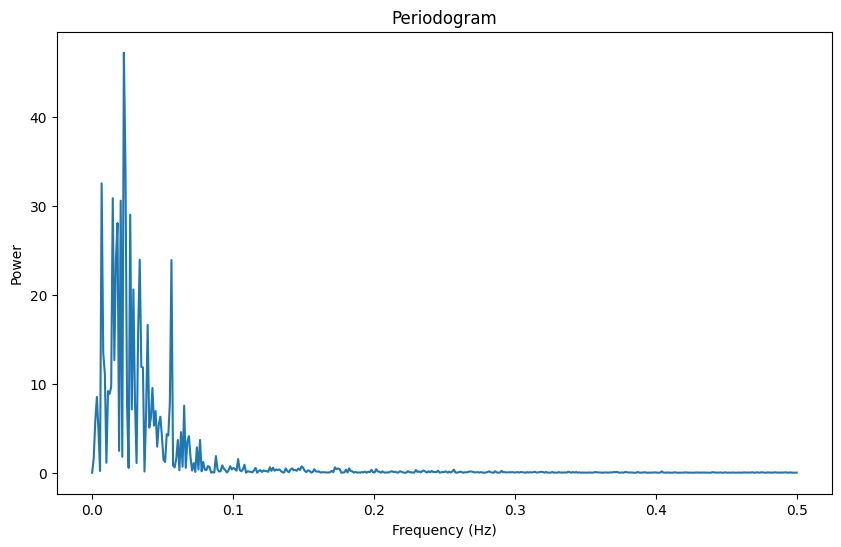

Dominant Frequency: 0.02252252252252252 Hz
Corresponding Period: 44.4 units


In [ ]:
dataset = pd.read_excel("/content/drive/MyDrive/FARIZA ALAMANDA PUTRI/Magang BMKG/Data_ENSO_Multivariate_NOAA (bulanan).xlsx")
enso_data = dataset['Nino34_anom']

# Compute the periodogram
frequencies, power = periodogram(enso_data)

# Plot the periodogram
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Periodogram')
plt.show()

# Identify the dominant frequency
dominant_frequency = frequencies[np.argmax(power)]
period = 1 / dominant_frequency
print(f"Dominant Frequency: {dominant_frequency} Hz")
print(f"Corresponding Period: {period} units")